# Executive Summary of Customer Churn Prediction Analysis

This notebook presents a sophisticated analysis aimed at predicting customer churn , utilizing logistic regression and random forest classifiers. The focus is twofold: to predict churn with precision and to unearth the underlying reasons behind customer departure. This comprehensive analysis is structured to maximize clarity, depth, and practical applicability of insights, thereby enabling strategic customer retention initiatives.

### Key Components of the Analysis:

#### Data Preparation and Enrichment:
- **Foundational Cleanliness**: Initiates with rigorous data cleaning, including datatype optimizations and handling missing values, to ensure data integrity.
- **Enhanced Feature Set**: Develops a richer dataset through meticulous feature engineering, including indicators for sales performance and customer buying patterns, enriching the dataset for nuanced analysis.
- **RFM Score Integration**: Incorporates RFM (Recency, Frequency, Monetary) segmentation with transaction data, offering a holistic view of customer engagement and value.

#### Predictive Modeling and Evaluation:
- **Strategic Data Segmentation**: Employs a temporal split to differentiate between historical and future customer behavior, laying the groundwork for predictive modeling.
- **Robust Modeling Strategy**: Engages logistic regression and random forest models, finely tuned for optimal performance and evaluated through comprehensive metrics to ensure predictive accuracy.
- **Model Selection Based on Performance**: Utilizes a systematic evaluation approach, selecting the model that best predicts churn based on accuracy, ROC AUC, and additional performance metrics.

#### Insights on Feature Importance and Model Interpretability:
- **Detailed Feature Importance Analysis**: Digs into the significance of various features in influencing churn predictions, identifying critical factors that drive customer retention or departure.
- **Interpretability Through LIME**: Applies LIME to provide interpretable explanations for model predictions, enhancing trust and understanding in the predictive process.
- **Advanced Visualization Techniques**: Deploys visualizations to succinctly convey the importance of features and the logic behind model predictions, making complex analyses accessible and insightful.

### Conclusion and Strategic Implications:

The depth and rigor of this analysis not only forecast customer churn with high accuracy but also illuminate the drivers behind such behavior. These insights pave the way for targeted, effective retention strategies that are critical for enhancing customer loyalty and driving sustainable business growth. Executives and decision-makers are provided with a roadmap to understanding customer churn dynamics, equipped to take strategic actions that mitigate churn and enhance customer engagement.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import numpy as np

# Data Preparation and Feature Engineering:
- **Data Cleaning**: Initial steps involve cleaning the dataset by converting date fields to datetime objects, adjusting data types for efficiency (e.g., converting IDs and quantities to integer types, and monetary values to float types), and handling missing values where necessary.
- **Feature Creation**: New features are engineered to enhance model input, including indicators for negative and zero sales, order processing times, purchase intervals, and categorical conversions for easier analysis and model training.
- **RFM Analysis Integration**: The RFM (Recency, Frequency, Monetary) scores previously calculated are integrated with the transaction dataset, aligning customer behavior metrics with transactional data for a holistic view of customer activity.


In [ ]:
transaction_data = pd.read_csv('cleaned_transactions.csv')

In [ ]:
# converting the column date_order and date_invoice from object (yyyy-mm-dd) to datetime
transaction_data['date_order'] = pd.to_datetime(transaction_data['date_order'])
transaction_data['date_invoice'] = pd.to_datetime(transaction_data['date_invoice'])

# Convert order_processing_time and purchase_interval to appropriate data type (float32)
transaction_data['order_processing_time'] = transaction_data['order_processing_time'].astype('float32')
transaction_data['purchase_interval'] = transaction_data['purchase_interval'].astype('float32')

# Convert product_id, client_id, and branch_id to unsigned integer data type
transaction_data['product_id'] = transaction_data['product_id'].astype('uint32')
transaction_data['client_id'] = transaction_data['client_id'].astype('uint32')
transaction_data['branch_id'] = transaction_data['branch_id'].astype('uint16')

# Convert sales_net to appropriate data type, considering its currency (e.g., float16 or float32)
transaction_data['sales_net'] = transaction_data['sales_net'].astype('float32')

# Convert quantity to appropriate data type, considering it's an integer
transaction_data['quantity'] = transaction_data['quantity'].astype('uint16')

# Convert month_year to period[M]
transaction_data['month_year'] = pd.to_datetime(transaction_data['month_year']).dt.to_period('M')

# Convert previous_order_date to datetime64[ns]
transaction_data['previous_order_date'] = pd.to_datetime(transaction_data['previous_order_date'])

In [ ]:
rfm_score = pd.read_csv('rfm_SC.csv')

In [ ]:
rfm_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170586 entries, 0 to 170585
Data columns (total 21 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   client_id                       170586 non-null  int64  
 1   frequency                       170586 non-null  float64
 2   recency                         170586 non-null  float64
 3   T                               170586 non-null  float64
 4   monetary_value                  170586 non-null  float64
 5   alive_probability               170586 non-null  float64
 6   RecencyScore                    170586 non-null  int64  
 7   FrequencyScore                  170586 non-null  int64  
 8   MonetaryScore                   170586 non-null  int64  
 9   RFM_Segment                     170586 non-null  int64  
 10  RFM_Score                       170586 non-null  int64  
 11  RFM_Level                       170586 non-null  object 
 12  predicted_purcha

In [ ]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63319315 entries, 0 to 63319314
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   date_order             datetime64[ns]
 1   date_invoice           datetime64[ns]
 2   product_id             uint32        
 3   client_id              uint32        
 4   sales_net              float32       
 5   quantity               uint16        
 6   order_channel          object        
 7   branch_id              uint16        
 8   month_year             period[M]     
 9   order_processing_time  float32       
 10  previous_order_date    datetime64[ns]
 11  purchase_interval      float32       
dtypes: datetime64[ns](3), float32(3), object(1), period[M](1), uint16(2), uint32(2)
memory usage: 3.8+ GB


In [ ]:
# Convert client_id in rfm_score to uint32 to match transaction_data
rfm_score['client_id'] = rfm_score['client_id'].astype('uint32')

# Verify the conversion
print(f"rfm_score client_id type after conversion: {rfm_score['client_id'].dtype}")

rfm_score client_id type after conversion: uint32


In [ ]:
# Step 1: Implement the frequency counts for 0 and negative sales in the transaction_data
transaction_data['is_negative_sale'] = transaction_data['sales_net'] < 0
transaction_data['is_zero_sale'] = transaction_data['sales_net'] == 0

# Step 2: Perform the temporal split based on date_order
split_date = transaction_data['date_order'].max() - timedelta(weeks=8)

pre_8w_data = transaction_data[transaction_data['date_order'] <= split_date]
post_8w_data = transaction_data[transaction_data['date_order'] > split_date]

In [ ]:
# Step 3: Aggregate the split datasets by client_id, creating features that reflect transaction behaviour and inactivity
# Adjusting the aggregation for pre_26w_data and post_26w_data
def aggregate_data(data):
    aggregated_data = data.groupby('client_id').agg({
        'sales_net': ['sum', 'mean'],
        'is_negative_sale': ['mean', 'sum'],  # Now includes count (sum) of negative sales
        'is_zero_sale': ['mean', 'sum'],  # Now includes count (sum) of zero sales
        'quantity': ['sum', 'mean'],
        'order_processing_time': ['mean', 'std'],  # Includes mean and standard deviation
        'order_channel': lambda x: x.mode()[0] if not x.mode().empty else None
    }).reset_index()

    # Flattening the multi-level column names
    aggregated_data.columns = ['_'.join(col).strip() for col in aggregated_data.columns.values]
    return aggregated_data

aggregated_pre_8w = aggregate_data(pre_8w_data)
aggregated_post_8w = aggregate_data(post_8w_data)

In [ ]:
# Rename 'client_id_' to 'client_id' in both aggregated DataFrames
aggregated_pre_8w.rename(columns={'client_id_': 'client_id'}, inplace=True)
aggregated_post_8w.rename(columns={'client_id_': 'client_id'}, inplace=True)

In [ ]:
# Step 4: Merge the aggregated datasets with the rfm_score
# Ensuring inner join to match client_ids
merged_pre_8w_with_rfm = pd.merge(aggregated_pre_8w, rfm_score, on='client_id', how='inner')
merged_post_8w_with_rfm = pd.merge(aggregated_post_8w, rfm_score, on='client_id', how='inner')

In [ ]:
merged_post_8w_with_rfm.columns

Index(['client_id', 'sales_net_sum', 'sales_net_mean', 'is_negative_sale_mean',
       'is_negative_sale_sum', 'is_zero_sale_mean', 'is_zero_sale_sum',
       'quantity_sum', 'quantity_mean', 'order_processing_time_mean',
       'order_processing_time_std', 'order_channel_<lambda>', 'frequency',
       'recency', 'T', 'monetary_value', 'alive_probability', 'RecencyScore',
       'FrequencyScore', 'MonetaryScore', 'RFM_Segment', 'RFM_Score',
       'RFM_Level', 'predicted_purchases', 'clv', 'product_diversity',
       'order_size_variability', 'rolling_recency', 'days_since_last_major',
       'most_common_purchase_month', 'segment_specific_risk_of_churn',
       'churned'],
      dtype='object')

## Now Prepare the Data for Modeling

- The target variable Is_Churned indicates whether a client will churn in the next 26 weeks
- Handling categorical column 'RFM_Level' with ColumnTransformer

### The above code returns numpy arrays, reconstructing the DataFrame with the original column names.

In [ ]:
# Retrieve the column names for one-hot encoded columns
onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
numeric_columns = [col for col in X_train.columns if col not in categorical_cols]

# Combine all transformed column names
transformed_columns = np.append(numeric_columns, onehot_columns)

# Convert the transformed arrays back into dataframes with the appropriate column names
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_columns, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_columns, index=X_test.index)

In [ ]:
# checking for null values in the transformed data
print(f"Missing values in merged_pre_8w_with_rfm: {merged_pre_8w_with_rfm.isna().sum()}")
print(f"Missing values in merged_pre_8w_with_rfm: {merged_post_8w_with_rfm.isna().sum()}")

Missing values in merged_pre_8w_with_rfm: client_id                             0
sales_net_sum                         0
sales_net_mean                        0
is_negative_sale_mean                 0
is_negative_sale_sum                  0
is_zero_sale_mean                     0
is_zero_sale_sum                      0
quantity_sum                          0
quantity_mean                         0
order_processing_time_mean            0
order_processing_time_std          6296
order_channel_<lambda>                0
frequency                             0
recency                               0
T                                     0
monetary_value                        0
alive_probability                     0
RecencyScore                          0
FrequencyScore                        0
MonetaryScore                         0
RFM_Segment                           0
RFM_Score                             0
RFM_Level                             0
predicted_purchases               2202

In [ ]:
# print the columns with missing values
print(f"Missing values in merged_pre_26w_with_rfm: {merged_pre_8w_with_rfm.isna().sum()}")
print(f"Missing values in merged_post_26w_with_rfm: {merged_post_8w_with_rfm.isna().sum()}")
# remove the columns with missing values
merged_pre_8w_with_rfm.dropna(inplace=True)
merged_post_8w_with_rfm.dropna(inplace=True)

Missing values in merged_pre_26w_with_rfm: client_id                             0
sales_net_sum                         0
sales_net_mean                        0
is_negative_sale_mean                 0
is_negative_sale_sum                  0
is_zero_sale_mean                     0
is_zero_sale_sum                      0
quantity_sum                          0
quantity_mean                         0
order_processing_time_mean            0
order_processing_time_std          6296
order_channel_<lambda>                0
frequency                             0
recency                               0
T                                     0
monetary_value                        0
alive_probability                     0
RecencyScore                          0
FrequencyScore                        0
MonetaryScore                         0
RFM_Segment                           0
RFM_Score                             0
RFM_Level                             0
predicted_purchases               220

In [ ]:
# counting null values in the merged data summing up the null values
print(f"Missing values in merged_pre_26w_with_rfm: {merged_pre_8w_with_rfm.isna().sum().sum()}")
print(f"Missing values in merged_pre_26w_with_rfm: {merged_post_8w_with_rfm.isna().sum().sum()}")

Missing values in merged_pre_26w_with_rfm: 0
Missing values in merged_pre_26w_with_rfm: 0


In [ ]:
# Drop the target variable to create features DataFrame and define the target
X = merged_pre_8w_with_rfm.drop(['segment_specific_risk_of_churn'], axis=1)
y = merged_pre_8w_with_rfm['segment_specific_risk_of_churn']

# Model Training , Evaluation, Feature Importance and Model Insights:
- **Splitting the Dataset**: The data isy spliedt to createtwo dataset seerving as a basis for training models on past behavior to predict future churn.
- **Model Selection and Training**: Logistic Regression and Random Forest models are traineta, with features carefully selected and preprocessed to optimize model performance.
- **Evaluation Metrics and Comparison**: Models are evaluated using a variety of metrics including accuracy, ROC AUC score, confusion matrix, and classification reports. The comparison aims to identify the model that best captures the nuances of customer chu
- **Feature Importance Exploration**: For the selected model, the importance of each feature is examined to discern their impact on predicting churn, providing actionable insights into which factors most influence customer retention decisions.
- **Interpretable Machine Learning with LIME**: LIME (Local Interpretable Model-agnostic Explanations) is applied to model predictions to explain the rationale behind individual churn predictions, enhancing transparency and trust in the model's decisions.
- **Advanced Visualizations**: Visual representations of feature importance, model predictions, and LIME explanations are utilized to convey complex insights in an accessible manner, aiding in the interpretation and application of the analysis findings.
n.


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# Assuming X and y are already defined as per previous steps

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Update to exclude datetime columns from scaling and encoding
datetime_cols = [col for col in X_train.columns if X_train[col].dtype == 'datetime64[ns]']
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object' and col not in datetime_cols]
numeric_cols = [col for col in X_train.columns if col not in categorical_cols + datetime_cols + ['client_id']]

# Apply OneHotEncoder to categorical data and StandardScaler to numeric data
# Separate transformer for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Separate transformer for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# Update preprocessor to only include specified transformers, without 'remainder' handling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit and transform the training data; transform the test data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [ ]:
# Retrieve the column names for one-hot encoded columns and combine with numeric and untouched columns
onehot_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
transformed_columns = np.concatenate([numeric_cols, onehot_columns])

# Since datetime columns were not transformed or included in the ColumnTransformer, they are not in the transformed data
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_columns, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_columns, index=X_test.index)

In [ ]:
# Verify the DataFrame creation
X_train_transformed_df

sales_net_sum  sales_net_mean  is_negative_sale_mean  \
2137        -0.105685       -0.163483              -0.546855   
143376      -0.165287        0.005690              -0.579627   
112112      -0.230859       -0.151125              -0.286773   
900         -0.247960       -0.289081               6.003237   
59984       -0.208356       -0.141747              -0.579627   
...               ...             ...                    ...   
127549      -0.196946       -0.043044              -0.405397   
138649      -0.244870       -0.146584              -0.579627   
119916      -0.184056       -0.048477               1.191999   
152643      -0.224607        0.411946              -0.579627   
141038      -0.113306       -0.146864              -0.111723   

        is_negative_sale_sum  is_zero_sale_mean  is_zero_sale_sum  \
2137               -0.228584           0.094110          0.079952   
143376             -0.244721          -0.740877         -0.277074   
112112             -0.228584          -0.740877         -0.277074   
900                -0.067210          -0.740877         -0.277074   
59984              -0.244721          -0.567266         -0.259223   
...                      ...                ...               ...   
127549             -0.228584          -0.740877         -0.277074   
138649             -0.244721          -0.740877         -0.277074   
119916             -0.034935          -0.740877         -0.277074   
152643             -0.244721          -0.740877         -0.277074   
141038             -0.051072           0.053898          0.008547   

        quantity_sum  quantity_mean  order_processing_time_mean  \
2137       -0.092531      -0.109791                   -0.178089   
143376     -0.068642       0.209260                   -0.239293   
112112     -0.140424      -0.114368                    0.741260   
900        -0.140535      -0.050576                    2.302316   
59984      -0.133100      -0.109541                   -0.216957   
...              ...            ...                         ...   
127549     -0.114301       0.036963                   -0.157278   
138649     -0.143796      -0.046470                   -0.455889   
119916     -0.126101      -0.072428                    0.865343   
152643     -0.140408       0.052660                   -0.487768   
141038      0.000181       0.043816                   -0.373438   

        order_processing_time_std  ...  churned  \
2137                     0.164174  ...      0.0   
143376                  -0.341622  ...      0.0   
112112                   0.219445  ...      0.0   
900                      1.398729  ...      0.0   
59984                    0.039892  ...      0.0   
...                           ...  ...      ...   
127549                  -0.196333  ...      0.0   
138649                  -0.649689  ...      0.0   
119916                   1.427069  ...      0.0   
152643                  -0.717617  ...      0.0   
141038                  -0.405671  ...      0.0   

        order_channel_<lambda>_by phone  \
2137                                0.0   
143376                              1.0   
112112                              0.0   
900                                 0.0   
59984                               0.0   
...                                 ...   
127549                              1.0   
138649                              0.0   
119916                              1.0   
152643                              0.0   
141038                              0.0   

        order_channel_<lambda>_during the visit of a sales rep  \
2137                                                  0.0        
143376                                                0.0        
112112                                                0.0        
900                                                   0.0        
59984                                                 0.0        
...                                                   ...        
127549       

## Step 1: Train the Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model using the transformed and preprocessed training data
model.fit(X_train_transformed_df, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_transformed_df)
y_pred_proba = model.predict_proba(X_test_transformed_df)[:, 1]  # Probability estimates for the positive class

In [ ]:
# Evaluation metrics
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.866851980542043
ROC AUC Score: 0.8945386506679704
Confusion Matrix:
 [[12058  2753]
 [ 1079 12890]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.81      0.86     14811
           1       0.82      0.92      0.87     13969

    accuracy                           0.87     28780
   macro avg       0.87      0.87      0.87     28780
weighted avg       0.87      0.87      0.87     28780



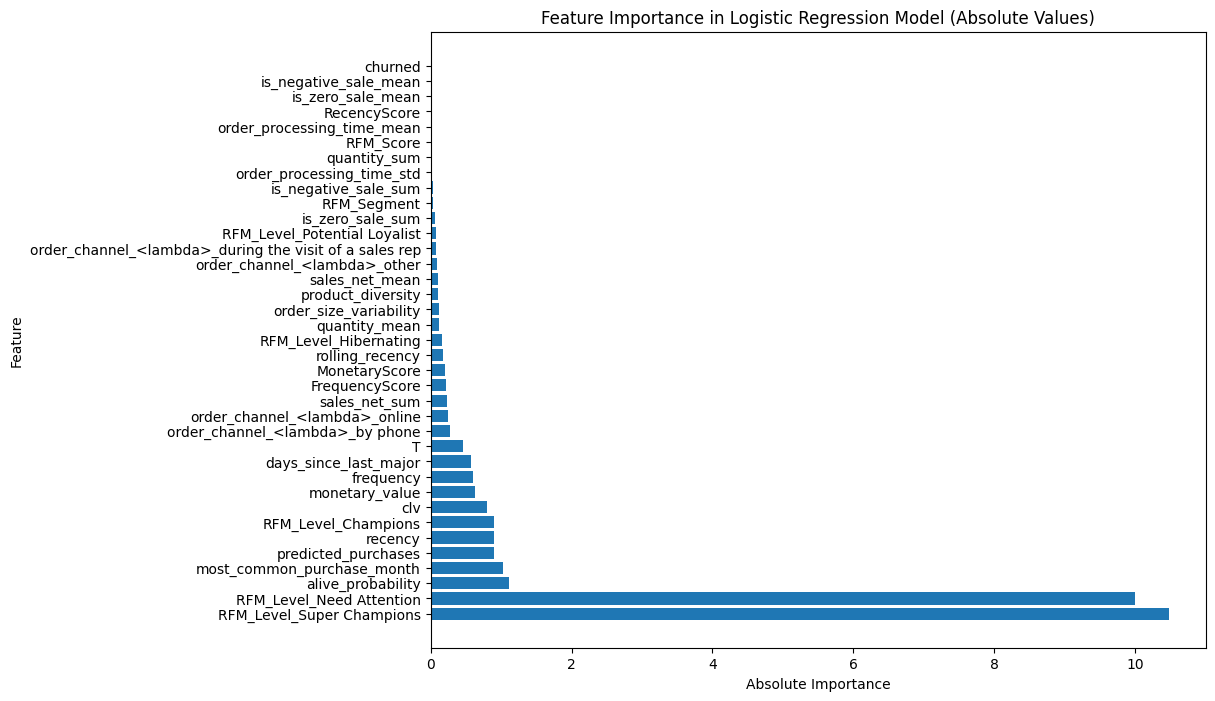

In [ ]:
import matplotlib.pyplot as plt

# Extracting the coefficients of the logistic regression model
coefficients = model.coef_[0]

# Creating a dataframe for the feature names and their corresponding coefficients
feature_importance = pd.DataFrame(X_train_transformed_df.columns, columns=['Feature'])
feature_importance['Importance'] = abs(coefficients)  # Using absolute values

# Sorting the features by their importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Visualizing the feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Absolute Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Model (Absolute Values)')
plt.show()

   Threshold      Lift  Precision  Recall
0   0.000000  1.000000   0.485372     1.0
1   0.000556  1.216142   0.590281     1.0
2   0.001111  1.272550   0.617660     1.0
3   0.001667  1.301497   0.631710     1.0
4   0.002222  1.316199   0.638846     1.0


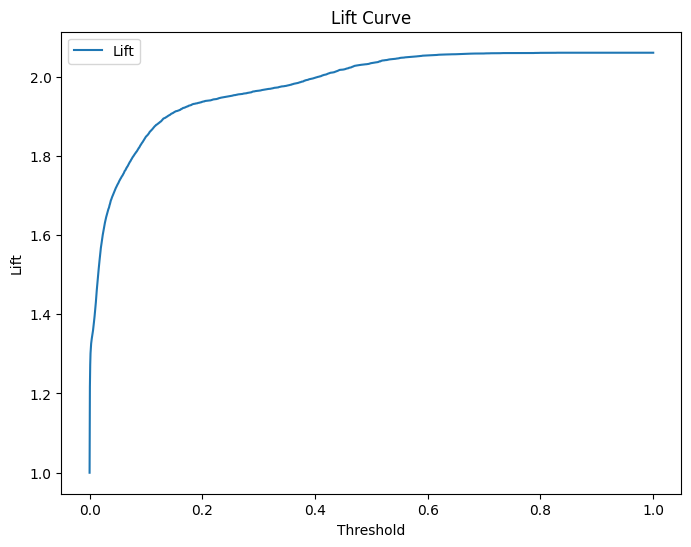

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import pandas as pd

# Assuming y_pred_proba contains the probability estimates of the positive class from your logistic regression model
y_scores_lr = y_pred_proba  # Probability estimates for the positive class

# Calculate precision and recall for different thresholds
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, y_scores_lr)

# Assuming a baseline churn rate (i.e., the proportion of positive instances in your dataset)
baseline_churn_rate = y_test.mean()

# Calculate lift scores by dividing precision by the baseline rate
lift_scores_lr = precision_lr / baseline_churn_rate

# Create a DataFrame to store precision, recall, thresholds, and lift scores
lift_df_lr = pd.DataFrame({
    'Threshold': np.append(thresholds_lr, 1),  # Appending 1 to match the dimensions
    'Lift': lift_scores_lr,
    'Precision': precision_lr,
    'Recall': recall_lr
})

# Displaying the first few rows of the DataFrame
print(lift_df_lr.head())

# You might also want to visualize the lift curve, though it's less common for logistic regression
plt.figure(figsize=(8, 6))
plt.plot(lift_df_lr['Threshold'], lift_df_lr['Lift'], label='Lift')
plt.xlabel('Threshold')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend()
plt.show()

# Optionally, you can save the DataFrame to a CSV for further analysis or sharing
# lift_df_lr.to_csv('logistic_regression_lift_scores.csv', index=False)


## Random Forest classifier for churn prediction

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Initialize the Random Forest classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using the transformed and preprocessed training data
random_forest_model.fit(X_train_transformed_df, y_train)

# Make predictions on the test set
y_pred_rf = random_forest_model.predict(X_test_transformed_df)
y_pred_proba_rf = random_forest_model.predict_proba(X_test_transformed_df)[:, 1]  # Probability estimates for the positive class

# Evaluation metrics
print("Random Forest Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy Score: 0.9935719249478805
Random Forest ROC AUC Score: 0.9999710456797769
Random Forest Confusion Matrix:
 [[14630   181]
 [    4 13965]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     14811
           1       0.99      1.00      0.99     13969

    accuracy                           0.99     28780
   macro avg       0.99      0.99      0.99     28780
weighted avg       0.99      0.99      0.99     28780



In [ ]:
feature_importances = random_forest_model.feature_importances_
feature_names = X_train_transformed_df.columns

# Create a pandas Series for easier plotting and manipulation
importances = pd.Series(feature_importances, index=feature_names)

# Sort the feature importances in descending order for better visualization
sorted_importances = importances.sort_values(ascending=False)

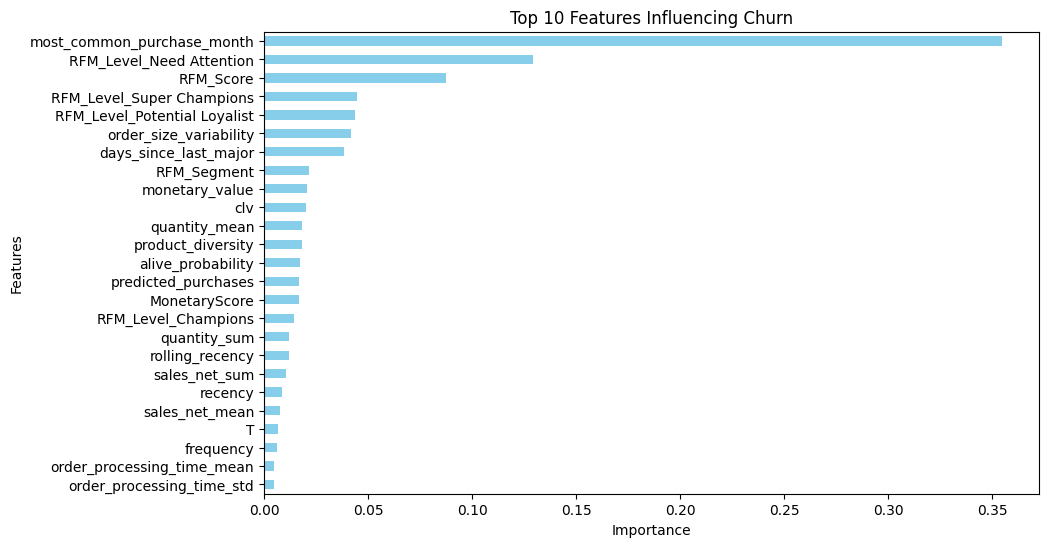

In [ ]:
import seaborn as sns

# Visualize the top N feature importances
top_n = 25  # Adjust based on how many top features you wish to display
sorted_importances[:top_n].plot(kind='barh', color='skyblue', figsize=(10, 6))
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Features Influencing Churn')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Assuming 'preprocessor' is your ColumnTransformer that handles data preprocessing

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

param_dist = {
    'classifier__n_estimators': [1800, 2500, 3000, 5000],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20, 30, 50]
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=5,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found: ", random_search.best_params_)

# Make predictions with the best found parameters
y_pred = random_search.predict(X_test)
y_pred_proba = random_search.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END classifier__criterion=gini, classifier__max_depth=50, classifier__n_estimators=1800; total time= 7.9min
[CV] END classifier__criterion=gini, classifier__max_depth=50, classifier__n_estimators=1800; total time= 7.9min
[CV] END classifier__criterion=gini, classifier__max_depth=50, classifier__n_estimators=1800; total time= 7.9min
[CV] END classifier__criterion=gini, classifier__max_depth=50, classifier__n_estimators=1800; total time= 7.9min
[CV] END classifier__criterion=gini, classifier__max_depth=50, classifier__n_estimators=1800; total time= 8.0min
[CV] END classifier__criterion=gini, classifier__max_depth=50, classifier__n_estimators=5000; total time=24.1min
[CV] END classifier__criterion=gini, classifier__max_depth=50, classifier__n_estimators=5000; total time=24.2min
[CV] END classifier__criterion=gini, classifier__max_depth=50, classifier__n_estimators=5000; total time=24.2min
[CV] END classifier__criterion=gini,

/Users/nawid/anaconda3/envs/myenvironment/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END classifier__criterion=gini, classifier__max_depth=30, classifier__n_estimators=5000; total time=24.7min
[CV] END classifier__criterion=gini, classifier__max_depth=30, classifier__n_estimators=5000; total time=24.7min
[CV] END classifier__criterion=gini, classifier__max_depth=30, classifier__n_estimators=5000; total time=24.7min
[CV] END classifier__criterion=gini, classifier__max_depth=30, classifier__n_estimators=5000; total time=24.7min
[CV] END classifier__criterion=entropy, classifier__max_depth=10, classifier__n_estimators=3000; total time=11.5min
[CV] END classifier__criterion=entropy, classifier__max_depth=10, classifier__n_estimators=3000; total time=11.5min
[CV] END classifier__criterion=entropy, classifier__max_depth=10, classifier__n_estimators=3000; total time=11.5min
[CV] END classifier__criterion=entropy, classifier__max_depth=10, classifier__n_estimators=3000; total time=11.5min
[CV] END classifier__criterion=entropy, classifier__max_depth=10, classifier__n_esti

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Initialize a simpler Random Forest model
rf_model_simplified = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=4, random_state=42)

# IMPORTANT: Fit the model on the preprocessed training data (X_train_transformed_df)
rf_model_simplified.fit(X_train_transformed_df, y_train)

# Make predictions on the preprocessed test data (X_test_transformed_df)
y_pred_simplified = rf_model_simplified.predict(X_test_transformed_df)
y_pred_proba_simplified = rf_model_simplified.predict_proba(X_test_transformed_df)[:, 1]

# Evaluation metrics
print(" Random Forest Accuracy Score:", accuracy_score(y_test, y_pred_simplified))
print(" Random Forest ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_simplified))
print(" Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_simplified))
print(" Random Forest Classification Report:\n", classification_report(y_test, y_pred_simplified))

 Random Forest Accuracy Score: 0.9730715774843641
 Random Forest ROC AUC Score: 0.9959999296067574
 Random Forest Confusion Matrix:
 [[14043   768]
 [    7 13962]]
 Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     14811
           1       0.95      1.00      0.97     13969

    accuracy                           0.97     28780
   macro avg       0.97      0.97      0.97     28780
weighted avg       0.97      0.97      0.97     28780



In [ ]:
# Calculate correlation matrix directly on the transformed DataFrame
corr_matrix = X_train_transformed_df.corr().abs()

# Select upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find indexes of feature columns with correlation greater than 0.95
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

# Drop highly correlated columns from both training and testing transformed DataFrames
X_train_transformed_df_dropped = X_train_transformed_df.drop(columns=highly_correlated_features)
X_test_transformed_df_dropped = X_test_transformed_df.drop(columns=highly_correlated_features)

# Print out the features that were dropped
print("Dropped features due to high correlation:", highly_correlated_features)

Dropped features due to high correlation: ['FrequencyScore', 'RFM_Segment', 'clv']


In [ ]:
# Fit the simplified Random Forest model on the updated training data
rf_model_simplified.fit(X_train_transformed_df_dropped, y_train)

# Make predictions on the updated test set
y_pred_dropped = rf_model_simplified.predict(X_test_transformed_df_dropped)
y_pred_proba_dropped = rf_model_simplified.predict_proba(X_test_transformed_df_dropped)[:, 1]

# Evaluation metrics for the model trained on data with dropped features
print("Accuracy Score after dropping features:", accuracy_score(y_test, y_pred_dropped))
print("ROC AUC Score after dropping features:", roc_auc_score(y_test, y_pred_proba_dropped))
print("Confusion Matrix after dropping features:\n", confusion_matrix(y_test, y_pred_dropped))
print("Classification Report after dropping features:\n", classification_report(y_test, y_pred_dropped))

Accuracy Score after dropping features: 0.9687630298818624
ROC AUC Score after dropping features: 0.9939511498446659
Confusion Matrix after dropping features:
 [[13916   895]
 [    4 13965]]
Classification Report after dropping features:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     14811
           1       0.94      1.00      0.97     13969

    accuracy                           0.97     28780
   macro avg       0.97      0.97      0.97     28780
weighted avg       0.97      0.97      0.97     28780



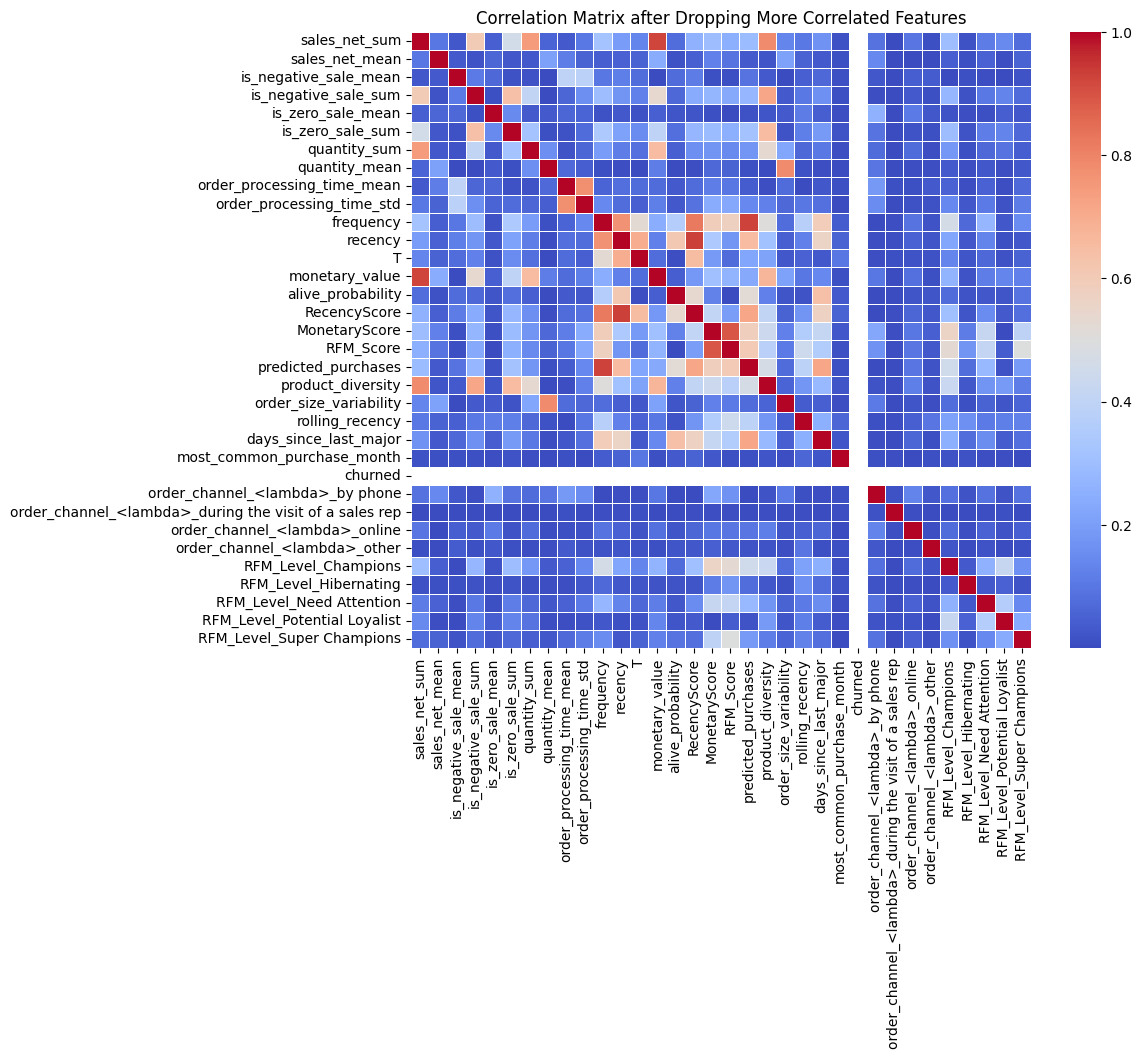

In [ ]:
# Calculate the correlation matrix
corr_matrix = X_train_transformed_df_dropped.corr().abs()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
            cmap='coolwarm',  # Choose a color scheme for the heatmap
            annot=False,      # Set to True if you want to see the correlation values
            linewidths=.5)    # Adds space between the cells

plt.title('Correlation Matrix after Dropping More Correlated Features')
plt.show()

In [ ]:
# Adjusting the correlation threshold to identify more correlated features
corr_threshold = 0.7
corr_matrix = X_train_transformed_df.corr().abs()

# Select upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find indexes of feature columns with correlation greater than the new threshold
more_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > corr_threshold)]

# Drop more correlated columns from both training and testing transformed DataFrames
X_train_transformed_df_dropped = X_train_transformed_df.drop(columns=more_correlated_features)
X_test_transformed_df_dropped = X_test_transformed_df.drop(columns=more_correlated_features)

# Print out the additional features that were dropped
print("Additional dropped features due to high correlation:", more_correlated_features)

Additional dropped features due to high correlation: ['num__quantity_sum', 'num__order_processing_time_std', 'num__recency', 'num__monetary_value', 'num__RecencyScore', 'num__FrequencyScore', 'num__RFM_Segment', 'num__RFM_Score', 'num__predicted_purchases', 'num__clv', 'num__product_diversity', 'num__order_size_variability', 'num__days_since_last_major', 'cat__order_channel_<lambda>_by phone']


In [ ]:
# Fit the model on the updated preprocessed training data
rf_model_reg.fit(X_train_transformed_df_dropped, y_train)

# Make predictions on the updated preprocessed test data
y_pred_dropped = rf_model_reg.predict(X_test_transformed_df_dropped)  # Updated variable name
y_pred_proba_dropped = rf_model_reg.predict_proba(X_test_transformed_df_dropped)[:, 1]  # Updated variable name

# Evaluation metrics for the model trained on data with dropped features
print("Accuracy Scores:", accuracy_score(y_test, y_pred_dropped))  # Updated print statement
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_dropped))  # Updated print statement
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dropped))  # Updated print statement
print("Classification Report:\n", classification_report(y_test, y_pred_dropped))  # Updated print statement


Accuracy Scores: 0.9418346073662266
ROC AUC Score: 0.9881117684030998
Confusion Matrix:
 [[13708  1103]
 [  571 13398]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94     14811
           1       0.92      0.96      0.94     13969

    accuracy                           0.94     28780
   macro avg       0.94      0.94      0.94     28780
weighted avg       0.94      0.94      0.94     28780



In [ ]:
# Extracting feature importances
feature_importances = rf_model_reg.feature_importances_

# Creating a DataFrame for feature names and their importance
features_df = pd.DataFrame({
    'Feature': X_train_transformed_df_dropped.columns,
    'Importance': feature_importances
})

# Sorting the DataFrame by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("Feature Importances from RandomForest Model:")
print(features_df.head(20))

Feature Importances from RandomForest Model:
                                     Feature  Importance
0            num__most_common_purchase_month    0.347051
1              cat__RFM_Level_Need Attention    0.201578
2             cat__RFM_Level_Super Champions    0.092137
3          cat__RFM_Level_Potential Loyalist    0.076507
4                   cat__RFM_Level_Champions    0.045322
5                     cat__RFM_Level_At Risk    0.042404
6                     num__alive_probability    0.039394
7                         num__quantity_mean    0.035592
8                         num__MonetaryScore    0.035508
9                         num__sales_net_sum    0.018057
10                      num__rolling_recency    0.016622
11                            num__frequency    0.016171
12                                    num__T    0.013262
13                       num__sales_net_mean    0.006553
14                 num__is_negative_sale_sum    0.002640
15                     num__is_zero_sale_su

In [ ]:
# Check the shape of y_pred_proba_dropped
print("Shape of y_pred_proba_dropped:", y_pred_proba_dropped.shape)

# Display the first few entries in y_pred_proba_dropped
print("First few probabilities in y_pred_proba_dropped:", y_pred_proba_dropped[:5])


Shape of y_pred_proba_dropped: (28780,)
First few probabilities in y_pred_proba_dropped: [0.19816529 0.86046847 0.90013114 0.21224051 0.13324868]


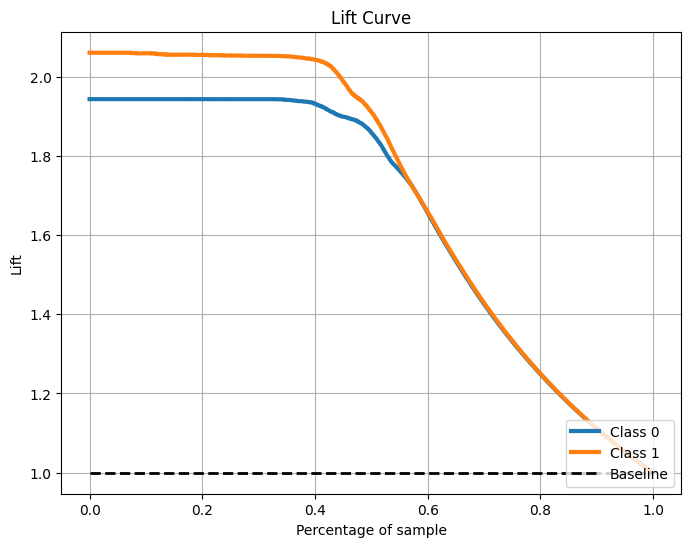

In [ ]:
# Constructing the 2D array for plot_lift_curve
prob_class_0 = 1 - y_pred_proba_dropped  # Probabilities for class 0
prob_class_1 = y_pred_proba_dropped      # Probabilities for class 1

# Stack them together to form a 2D array
y_pred_proba_2d = np.vstack((prob_class_0, prob_class_1)).T

# Now, plot the lift curve using the constructed 2D array
skplt.metrics.plot_lift_curve(y_test, y_pred_proba_2d, figsize=(8, 6))
plt.show()

In [ ]:
# Create a DataFrame with actual labels and predicted probabilities
data = pd.DataFrame({'Actual': y_test, 'Prob': y_pred_proba_dropped})

# Sort DataFrame by probabilities in descending order
data_sorted = data.sort_values(by='Prob', ascending=False)

# Calculate deciles
data_sorted['Decile'] = pd.qcut(data_sorted['Prob'], 10, labels=np.arange(1, 11))

# Calculate the cumulative number of positives (actual=1) up to each decile
data_sorted['Cumulative Positives'] = data_sorted.groupby('Decile')['Actual'].cumsum()

# Calculate cumulative positives at each decile (end of each decile)
cumulative_positives_at_decile = data_sorted.groupby('Decile')['Cumulative Positives'].last()

# Calculate total positives in the dataset
total_positives = data_sorted['Actual'].sum()

# Calculate the expected positives in each decile if random guessing (equal distribution)
expected_positives_per_decile = total_positives / 10

# Calculate lift at each decile
lift_at_decile = cumulative_positives_at_decile / (expected_positives_per_decile * np.arange(1, 11))

# Create a DataFrame to display the lift at each decile
lift_table = pd.DataFrame({
    'Decile': np.arange(1, 11),
    'Lift': lift_at_decile.values
})

print(lift_table)

   Decile      Lift
0       1  0.000000
1       2  0.000000
2       3  0.000000
3       4  0.012349
4       5  0.079891
5       6  0.230272
6       7  0.287371
7       8  0.256103
8       9  0.227806
9      10  0.205884


In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Adjust the explainer to use the training data with dropped features
explainer = LimeTabularExplainer(
    training_data=X_train_transformed_df_dropped.to_numpy(),
    feature_names=X_train_transformed_df_dropped.columns,
    class_names=['Not Churn', 'Churn'],
    mode='classification'
)

# Explain an individual prediction using the dropped features version of the test data
idx_to_explain = 17  # Example index, can be changed to any index of a sample in the test set
exp = explainer.explain_instance(X_test_transformed_df_dropped.iloc[idx_to_explain].to_numpy(), rf_model_reg.predict_proba, num_features=10)
# If in a Jupyter Notebook environment, you can use:
# exp.show_in_notebook(show_table=True)
# Otherwise, for a non-notebook environment, try:
exp.show_in_notebook(show_table=True)  # Adjust as necessary based on your environment

/Users/nawid/anaconda3/envs/myenvironment/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Indices for non-churning and churning clients remain the same
idx_non_churn = np.where(y_pred_dropped == 0)[0][0]  # Index for the first non-churn prediction
idx_churn = np.where(y_pred_dropped == 1)[0][0]     # Index for the first churn prediction

# Explain the prediction for a non-churning client using the dropped features version of the test data
exp_non_churn = explainer.explain_instance(X_test_transformed_df_dropped.iloc[idx_non_churn].to_numpy(), rf_model_reg.predict_proba, num_features=10)
# exp_non_churn.show_in_notebook(show_table=True)  # For Jupyter Notebook
exp_non_churn.show_in_notebook(show_table=True)  # Adjust as necessary

# Explain the prediction for a churning client using the dropped features version of the test data
exp_churn = explainer.explain_instance(X_test_transformed_df_dropped.iloc[idx_churn].to_numpy(), rf_model_reg.predict_proba, num_features=10)
# exp_churn.show_in_notebook(show_table=True)  # For Jupyter Notebook
exp_churn.show_in_notebook(show_table=True)  # Adjust as necessary

/Users/nawid/anaconda3/envs/myenvironment/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


/Users/nawid/anaconda3/envs/myenvironment/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


/Users/nawid/anaconda3/envs/myenvironment/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


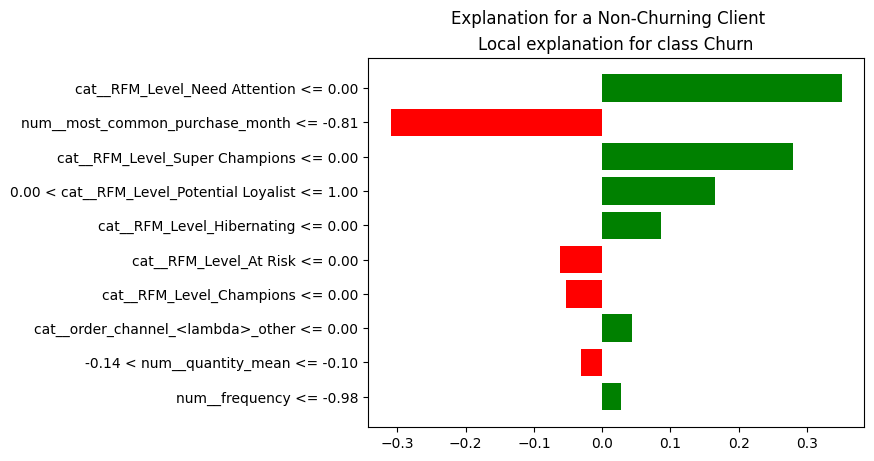

/Users/nawid/anaconda3/envs/myenvironment/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


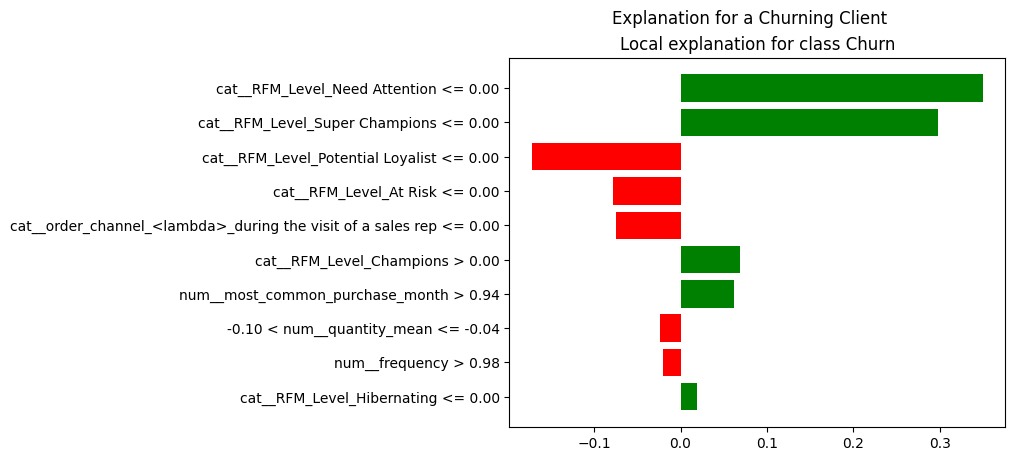

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Ensure we're using the DataFrame with the correct number of features for explanations
explainer = LimeTabularExplainer(
    training_data=X_train_transformed_df_dropped.to_numpy(),
    feature_names=X_train_transformed_df_dropped.columns,
    class_names=['Not Churn', 'Churn'],
    mode='classification'
)

# Now, when calling explainer.explain_instance, make sure to use the dropped features DataFrame
# Adjusting based on your previous variable naming for consistency

# For a non-churning client example
exp_non_churn = explainer.explain_instance(X_test_transformed_df_dropped.iloc[idx_non_churn].to_numpy(), rf_model_reg.predict_proba, num_features=10)
fig_non_churn = exp_non_churn.as_pyplot_figure()
fig_non_churn.suptitle('Explanation for a Non-Churning Client')
plt.show()

# For a churning client example
exp_churn = explainer.explain_instance(X_test_transformed_df_dropped.iloc[idx_churn].to_numpy(), rf_model_reg.predict_proba, num_features=10)
fig_churn = exp_churn.as_pyplot_figure()
fig_churn.suptitle('Explanation for a Churning Client')
plt.show()


In [ ]:
import pandas as pd

# Convert the LIME explanation for a non-churning client into a list
exp_list_non_churn = exp_non_churn.as_list()
# Convert the list into a DataFrame
df_non_churn = pd.DataFrame(exp_list_non_churn, columns=['Feature', 'Effect on Prediction'])
print("Explanation for a Non-Churning Client:")
print(df_non_churn)

# Convert the LIME explanation for a churning client into a list
exp_list_churn = exp_churn.as_list()
# Convert the list into a DataFrame
df_churn = pd.DataFrame(exp_list_churn, columns=['Feature', 'Effect on Prediction'])
print("\nExplanation for a Churning Client:")
print(df_churn)

Explanation for a Non-Churning Client:
                                             Feature  Effect on Prediction
0              cat__RFM_Level_Need Attention <= 0.00              0.364469
1           num__most_common_purchase_month <= -0.81             -0.307700
2             cat__RFM_Level_Super Champions <= 0.00              0.272589
3   0.00 < cat__RFM_Level_Potential Loyalist <= 1.00              0.175798
4  cat__order_channel_<lambda>_during the visit o...              0.079731
5          cat__order_channel_<lambda>_other <= 0.00             -0.079346
6                 cat__RFM_Level_Hibernating <= 0.00              0.071137
7                     cat__RFM_Level_At Risk <= 0.00             -0.062496
8                   cat__RFM_Level_Champions <= 0.00             -0.057203
9                            num__frequency <= -0.98              0.035942

Explanation for a Churning Client:
                                             Feature  Effect on Prediction
0              cat__RFM_L